In [20]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/pytorch_advanced/1_image_classification/
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/pytorch_advanced/1_image_classification
1-1_load_vgg.ipynb  data  make_folders_and_data_downloads.ipynb


In [0]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms

In [2]:
print('Pytorch Version: ', torch.__version__)
print('Torchvision Version: ', torchvision.__version__)

Pytorch Version:  1.3.1
Torchvision Version:  0.4.2


In [3]:
#学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスの生成
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.eval() # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# 入力画像の前処理のクラス
class BaseTransform():
    # 画像のリサイズ、色の標準化

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
                                                  transforms.Resize(resize), # 短い編の長さがresizeの大きさになる
                                                  transforms.CenterCrop(resize), #画像中央をresize x resizeで切り取る
                                                  transforms.ToTensor(), # Torchテンソルに変更
                                                  transforms.Normalize(mean, std) # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)

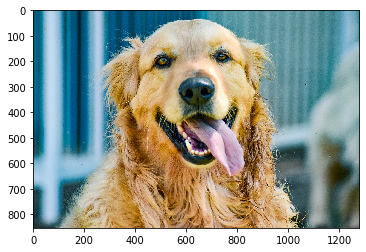

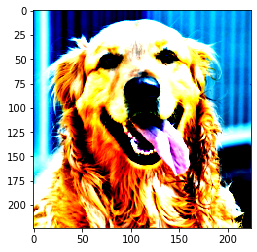

In [16]:
#前処理の動作確認

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

# 元画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済みの画像表示
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img) # torch.size([3, 224, 224])

# (色, 高さ, 幅) -> (高さ, 幅, 色)に変換し、0-1に値を制限して表示
img_transformed = transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [26]:
# ILSVRCのラベル情報をロードし辞書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [0]:
# 出力結果からラベルを予測する後処理クラス
class ILSVRCPredictor():
    """
    ILSVRCデータに対するモデルの出力からラベルを求める
    Attributes
    -------------------------------
    class_index : dictionary
        クラスindexとラベル名を対応させた辞書型変数
    -------------------------------
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        確率最大のILSVRCのラベル名を取得する
        Parameters
        -------------------------------
        out : torch.Size([1, 1000])
            Netからの出力

        Return
        -------------------------------
        Predicted_label_name : str
            もっとも予想確率が高いラベルの名前
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name

In [29]:
# ILSVRCのラベル情報をロードし辞書型変数を生成
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredictorのインスタンスを生成
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 入力画像を読み込む
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

# 前処理の後、バッチサイズの次元を追加する
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0)

# モデルに乳勒し、モデル出力をラベルに変換する
out = net(inputs)
result = predictor.predict_max(out)

# 予測結果を出力
print('入力画像の予測結果: ', result)

入力画像の予測結果:  golden_retriever
